In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter, get_scada_subset, get_weather_subset
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Get the data, models and predictions

In [15]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)

location = 'nw2d01'
name_location = 'NW2_D01'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [7]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [18]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.pyfunc.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print('no ' + stage + ' model ' + model_name)

In [19]:
weather_inputs = get_weather_subset(mvbc_data)
scada_inputs = get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [20]:
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

## Hypothesis Test for the data after training
Model training currently untill 01-03-2023

In [205]:
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

stop_training = datetime.datetime(2023, 3, 1, tzinfo=utc)

training_data = normalized.loc[normalized.index < stop_training]
testing_data = training_data #normalized.loc[stop_training:stop_training+datetime.timedelta(days=28)]

In [221]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
testing_days = [7]
test_end = testing_data.index[0]
p_values = {}
mwu_stats = {}

for testing_duration in testing_days:
    for mode in modes:
        columns=scouring_scenarios.copy()
        columns.insert(0, 'no_scour')
        p_val_mode = {}
        mwu_stat_mode = {}
        while test_end < testing_data.index[-2]:
            p_vals = {}
            mwus = {}
            test_data_ = testing_data.loc[test_end: test_end + datetime.timedelta(days=testing_duration)]
            if len(test_data_[mode].dropna()) > len(test_data_[mode]) * 0.5:
                mwu_stat, p_val = mannwhitneyu(training_data[mode].dropna(), test_data_[mode].dropna(), alternative='two-sided')
                p_vals['no_scour'] = p_val
                mwus['no_scour'] = mwu_stat
                for scouring_scenario in scouring_scenarios:
                    scour_population = \
                        training_data[mode] \
                        - (
                            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                            *training_data[mode]
                        )
                    mwu_stat, p_val = mannwhitneyu(scour_population.dropna(), test_data_[mode].dropna(), alternative='two-sided')
                    p_vals[scouring_scenario] = p_val
                    mwus[scouring_scenario] = mwu_stat
                p_val_mode[test_end] = p_vals
                mwu_stat_mode[test_end] = mwus
            else:
                Warning('Not enough data for ' + mode + ' ' + scouring_scenario + ' at time ' + str(test_end))
            test_end = test_data_.index[-1]
pd.DataFrame(p_val_mode).T

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2022-11-01 00:00:00+00:00,0.804794,1.216419e-05,5.737396e-58,1.567417e-107,8.796213e-223,0.000000e+00
2022-11-08 00:00:00+00:00,0.440969,9.741224e-05,6.311781e-66,7.632381e-125,3.059533e-254,0.000000e+00
2022-11-15 00:00:00+00:00,0.169512,4.776064e-03,4.179156e-50,7.008998e-99,5.266375e-215,0.000000e+00
2022-11-22 00:00:00+00:00,0.115505,2.114012e-08,3.627696e-64,2.848791e-113,3.219534e-223,0.000000e+00
2022-11-29 00:00:00+00:00,0.788091,3.046507e-07,4.635772e-78,2.926468e-142,2.935948e-279,0.000000e+00
2022-12-06 00:00:00+00:00,0.312194,2.433272e-04,4.125558e-65,1.241202e-125,5.779810e-263,0.000000e+00
2022-12-13 00:00:00+00:00,0.335491,3.348582e-04,6.044342e-62,4.949244e-119,2.976279e-247,0.000000e+00
2022-12-20 00:00:00+00:00,0.800924,2.150905e-05,8.546997e-65,2.087509e-121,4.377746e-248,0.000000e+00
2022-12-27 00:00:00+00:00,0.328591,1.520450e-06,5.611857e-55,2.193204e-99,2.462415e-202,0.000000e+00
2023-01-03 00:00:00+00:00,0.807864,4.497328e-05,3.570313e-51,1.867518e-95,2.685387e-200,0.000000e+00


<Figure size 1440x360 with 0 Axes>

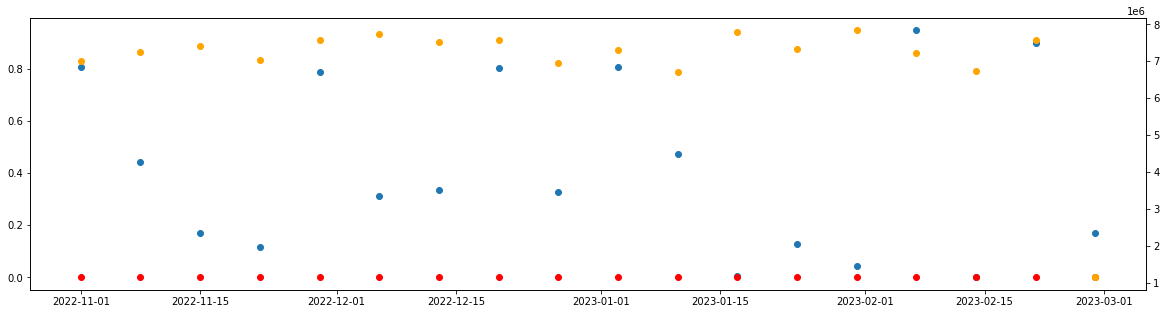

In [224]:
plt.figure(figsize=(20,5))
fig, ax1 = plt.subplots(figsize=(20,5))

ax2 = ax1.twinx()
ax1.scatter(pd.DataFrame(p_val_mode).T.index, pd.DataFrame(p_val_mode).T['no_scour'])
ax1.scatter(pd.DataFrame(p_val_mode).T.index, pd.DataFrame(p_val_mode).T['0.1D'], c='r')
ax2.scatter(pd.DataFrame(mwu_stat_mode).T.index, pd.DataFrame(mwu_stat_mode).T['no_scour'], color='orange')
plt.show()

In [201]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
testing_days = [2]
test_end = testing_data.index[0]
p_values = {}

for testing_duration in testing_days:
    for mode in modes:
        columns=scouring_scenarios.copy()
        columns.insert(0, 'no_scour')
        p_val_mode = {}
        while test_end < testing_data.index[-2]:
            p_vals = {}
            test_data_ = testing_data.loc[test_end: test_end + datetime.timedelta(days=testing_duration)]
            if len(test_data_[mode].dropna()) > len(test_data_[mode]) * 0.5:
                mwu_stat, p_val = ks_2samp(training_data[mode].dropna(), test_data_[mode].dropna(), alternative='two-sided')
                p_vals['no_scour'] = p_val
                for scouring_scenario in scouring_scenarios:
                    scour_population = \
                        training_data[mode] \
                        - (
                            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                            *training_data[mode]
                        )
                    mwu_stat, p_val = ks_2samp(scour_population.dropna(), test_data_[mode].dropna(), alternative='two-sided')
                    p_vals[scouring_scenario] = p_val
                p_val_mode[test_end] = p_vals
            else:
                Warning('Not enough data for ' + mode + ' ' + scouring_scenario + ' at time ' + str(test_end))
            test_end = test_data_.index[-1]
pd.DataFrame(p_val_mode).T

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2023-03-01 00:00:00+00:00,0.687178,8.220346e-02,3.609457e-18,8.834800e-35,1.326407e-79,2.477550e-144
2023-03-03 00:00:00+00:00,0.748181,3.670759e-03,2.485220e-21,9.206293e-39,4.453897e-77,6.317365e-136
2023-03-05 00:00:00+00:00,0.000014,1.299790e-11,2.704555e-40,4.374910e-60,2.173846e-111,9.459182e-179
2023-03-07 00:00:00+00:00,0.001091,3.865724e-01,1.794261e-12,5.858273e-27,4.312411e-66,4.227051e-123
2023-03-09 00:00:00+00:00,0.000171,1.216240e-01,1.687010e-06,1.922234e-14,3.996447e-45,5.164759e-100
2023-03-11 00:00:00+00:00,0.006581,5.737335e-06,4.728699e-23,1.778725e-39,1.795422e-80,1.473803e-141
2023-03-13 00:00:00+00:00,0.000008,1.024017e-08,6.268034e-20,2.841077e-28,3.673267e-49,3.597680e-83
2023-03-15 00:00:00+00:00,0.015872,1.309078e-06,8.563147e-29,1.660161e-49,1.540544e-93,5.225247e-149
2023-03-17 00:00:00+00:00,0.000287,8.236042e-09,8.254979e-36,1.007447e-56,2.415741e-104,1.034817e-172
2023-03-19 00:00:00+00:00,0.122829,5.061922e-05,5.483540e-26,2.356786e-42,4.318779e-90,6.896572e-155


In [200]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
testing_days = [2]
test_end = testing_data.index[0]
p_values = {}

for testing_duration in testing_days:
    for mode in modes:
        columns=scouring_scenarios.copy()
        columns.insert(0, 'no_scour')
        p_val_mode = {}
        while test_end < testing_data.index[-2]:
            p_vals = {}
            test_data_ = testing_data.loc[test_end: test_end + datetime.timedelta(days=testing_duration)]
            if len(test_data_[mode].dropna()) > len(test_data_[mode]) * 0.5:
                mwu_stat, p_val = ttest_ind(training_data[mode].dropna(), test_data_[mode].dropna(), alternative='two-sided')
                p_vals['no_scour'] = p_val
                for scouring_scenario in scouring_scenarios:
                    scour_population = \
                        training_data[mode] \
                        - (
                            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                            *training_data[mode]
                        )
                    mwu_stat, p_val = ttest_ind(scour_population.dropna(), test_data_[mode].dropna(), alternative='two-sided')
                    p_vals[scouring_scenario] = p_val
                p_val_mode[test_end] = p_vals
            else:
                Warning('Not enough data for ' + mode + ' ' + scouring_scenario + ' at time ' + str(test_end))
            test_end = test_data_.index[-1]
pd.DataFrame(p_val_mode).T

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2023-03-01 00:00:00+00:00,0.865711,3.979123e-02,4.743525e-18,2.771441e-35,5.258477e-86,2.044962e-180
2023-03-03 00:00:00+00:00,0.639021,7.956731e-03,6.435270e-20,1.560975e-37,2.280249e-88,9.035714e-182
2023-03-05 00:00:00+00:00,0.000681,1.820878e-08,1.907894e-34,1.947185e-57,3.087127e-119,6.436993e-227
2023-03-07 00:00:00+00:00,0.005834,5.861107e-01,1.651931e-09,1.802859e-22,8.549707e-65,7.375877e-149
2023-03-09 00:00:00+00:00,0.017874,7.954189e-01,1.902941e-09,1.233239e-21,6.646032e-61,2.122352e-138
2023-03-11 00:00:00+00:00,0.016450,4.317984e-06,1.144350e-28,1.734123e-49,1.272625e-106,8.141484e-208
2023-03-13 00:00:00+00:00,0.068284,1.498032e-04,5.959818e-22,2.922600e-38,1.848679e-83,2.487229e-164
2023-03-15 00:00:00+00:00,0.000248,5.232835e-09,1.090212e-34,4.214441e-57,6.079901e-117,9.965742e-221
2023-03-17 00:00:00+00:00,0.003557,3.503487e-07,7.055304e-31,3.333060e-52,4.840907e-110,1.369755e-211
2023-03-19 00:00:00+00:00,0.306597,1.360718e-03,3.986498e-22,1.556833e-40,8.012410e-93,7.832847e-188


In [204]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
testing_days = [2]
test_end = testing_data.index[0]
p_values = {}

for testing_duration in testing_days:
    for mode in modes:
        columns=scouring_scenarios.copy()
        columns.insert(0, 'no_scour')
        p_val_mode = {}
        while test_end < testing_data.index[-2]:
            p_vals = {}
            test_data_ = testing_data.loc[test_end: test_end + datetime.timedelta(days=testing_duration)]
            if len(test_data_[mode].dropna()) > len(test_data_[mode]) * 0.5:
                mwu_stat, p_val = mannwhitneyu(training_data[mode].dropna(), test_data_[mode].dropna(), alternative='greater')
                p_vals['no_scour'] = p_val
                for scouring_scenario in scouring_scenarios:
                    scour_population = \
                        training_data[mode] \
                        - (
                            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                            *training_data[mode]
                        )
                    mwu_stat, p_val = mannwhitneyu(scour_population.dropna(), test_data_[mode].dropna(), alternative='greater')
                    p_vals[scouring_scenario] = p_val
                p_val_mode[test_end] = p_vals
            else:
                Warning('Not enough data for ' + mode + ' ' + scouring_scenario + ' at time ' + str(test_end))
            test_end = test_data_.index[-1]
pd.DataFrame(p_val_mode).T

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2023-03-01 00:00:00+00:00,0.376186,0.988137,1.0,1.0,1.0,1.0
2023-03-03 00:00:00+00:00,0.759854,0.999250,1.0,1.0,1.0,1.0
2023-03-05 00:00:00+00:00,0.999992,1.000000,1.0,1.0,1.0,1.0
2023-03-07 00:00:00+00:00,0.000947,0.304594,1.0,1.0,1.0,1.0
2023-03-09 00:00:00+00:00,0.000591,0.148202,1.0,1.0,1.0,1.0
2023-03-11 00:00:00+00:00,0.993985,0.999999,1.0,1.0,1.0,1.0
2023-03-13 00:00:00+00:00,0.975502,0.999852,1.0,1.0,1.0,1.0
2023-03-15 00:00:00+00:00,0.999622,1.000000,1.0,1.0,1.0,1.0
2023-03-17 00:00:00+00:00,0.999815,1.000000,1.0,1.0,1.0,1.0
2023-03-19 00:00:00+00:00,0.930649,0.999976,1.0,1.0,1.0,1.0


In [225]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
testing_days = [2]
test_end = testing_data.index[0]
p_values = {}

scour_test_scenario = '0.1D'

for testing_duration in testing_days:
    for mode in modes:
        columns=scouring_scenarios.copy()
        columns.insert(0, 'no_scour')
        p_val_mode = {}
        while test_end < testing_data.index[-2]:
            p_vals = {}
            test_data_ = testing_data.loc[test_end: test_end + datetime.timedelta(days=testing_duration)]
            test_data_ = test_data_.loc[test_data_.index.drop_duplicates(keep='first')]
            scour_test = test_data_ - (simulation_shifts[operating_condition+'_scour'][mode][scour_test_scenario]/100 *test_data_)
            if len(test_data_[mode].dropna()) > len(test_data_[mode]) * 0.5:
                mwu_stat, p_val = mannwhitneyu(training_data[mode].dropna(), scour_test[mode].dropna(), alternative='two-sided')
                p_vals['no_scour'] = p_val
                for scouring_scenario in scouring_scenarios:
                    scour_population = \
                        training_data[mode] \
                        - (
                            simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                            *training_data[mode]
                        )
                    mwu_stat, p_val = mannwhitneyu(scour_population.dropna(), scour_test[mode].dropna(), alternative='two-sided')
                    p_vals[scouring_scenario] = p_val
                p_val_mode[test_end] = p_vals
            else:
                Warning('Not enough data for ' + mode + ' ' + scouring_scenario + ' at time ' + str(test_end))
            test_end = test_data_.index[-1]
pd.DataFrame(p_val_mode).T

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2022-11-01 00:00:00+00:00,4.624749e-15,3.428576e-09,0.997277,8.881421e-04,1.075804e-20,4.359590e-55
2022-11-03 00:00:00+00:00,2.058527e-20,3.369045e-12,0.751988,6.740342e-06,2.977171e-33,3.956653e-82
2022-11-05 00:00:00+00:00,8.448990e-17,7.274923e-10,0.610397,1.825676e-05,7.230583e-29,7.260780e-73
2022-11-07 00:00:00+00:00,1.860229e-20,5.209611e-13,0.459142,2.899054e-03,5.143763e-23,4.179559e-65
2022-11-09 00:00:00+00:00,2.972418e-26,1.179945e-17,0.054860,4.120827e-02,1.404254e-21,7.378792e-67
2022-11-11 00:00:00+00:00,1.111452e-32,1.183006e-21,0.084628,3.020743e-03,1.553404e-30,7.149303e-83
2022-11-13 00:00:00+00:00,8.632547e-15,2.128433e-07,0.004473,4.447730e-13,1.747378e-48,7.422702e-96
2022-11-15 00:00:00+00:00,2.561468e-23,1.835317e-15,0.118194,2.750813e-02,1.357178e-20,1.457428e-62
2022-11-17 00:00:00+00:00,7.082700e-17,1.917321e-10,0.897605,4.840138e-04,3.815223e-24,1.640558e-63
2022-11-19 00:00:00+00:00,3.604053e-28,2.313760e-18,0.154819,4.560079e-03,3.265342e-26,6.887121e-73


In [189]:
test_data_.index.duplicated()

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

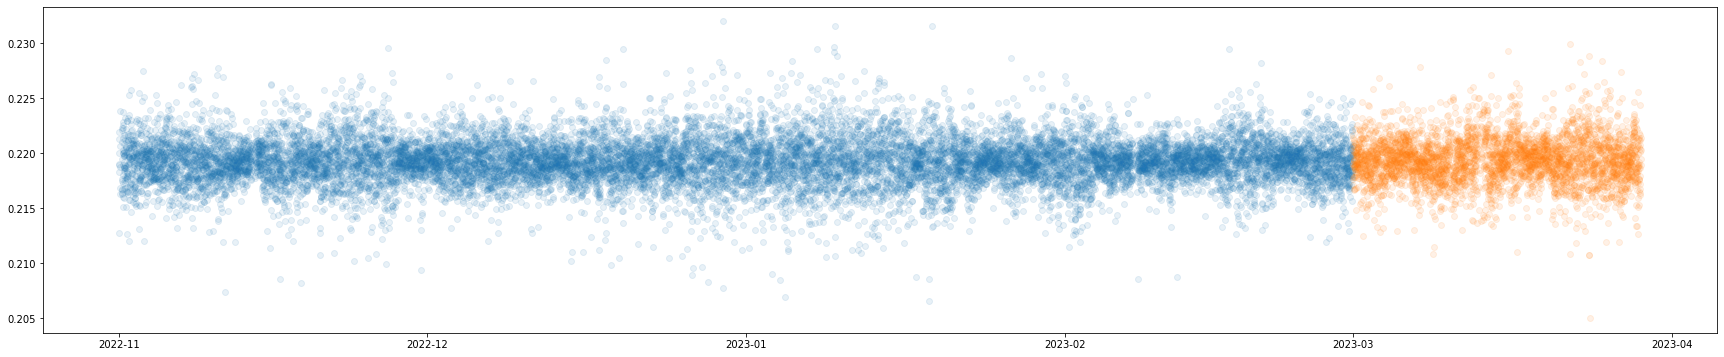

In [177]:
plt.figure(figsize=(30,6))
plt.scatter(training_data.index, training_data[mode], label='training', alpha=0.1)
plt.scatter(testing_data.index, testing_data[mode], label='testing', alpha = 0.1)

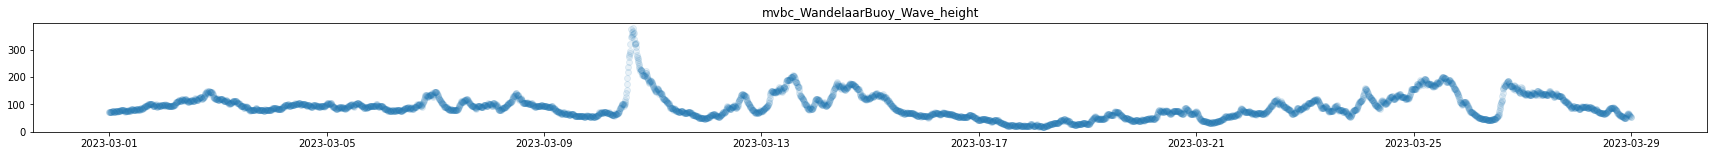

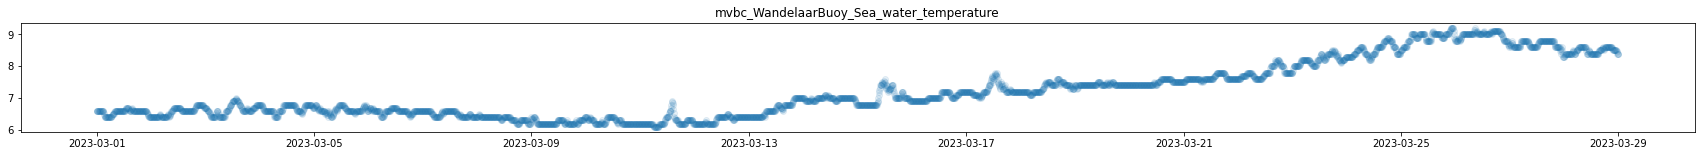

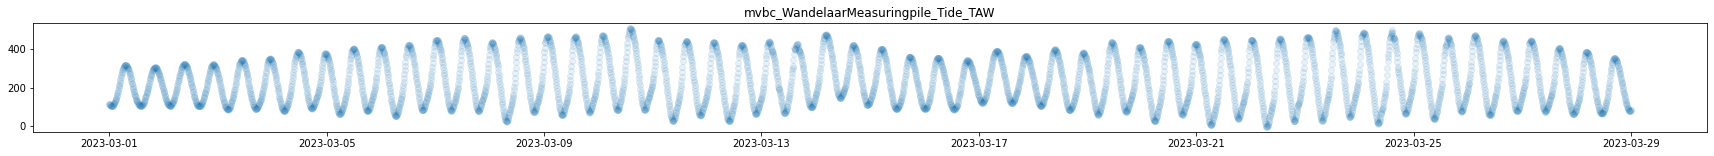

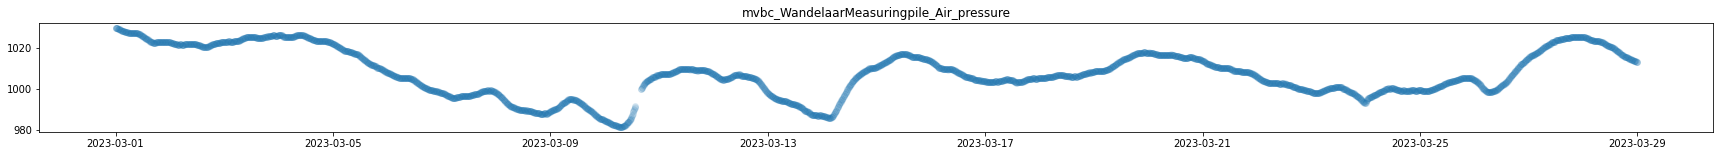

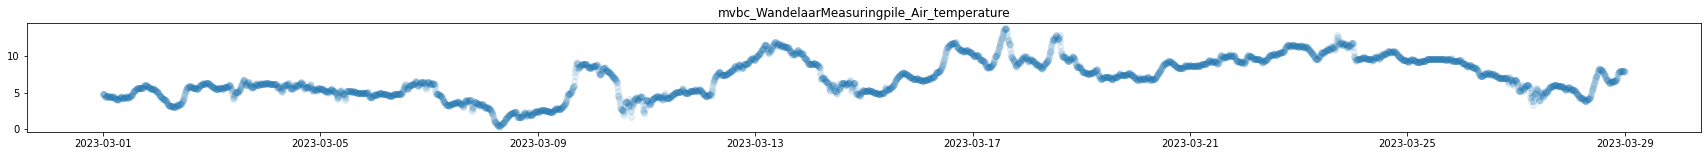

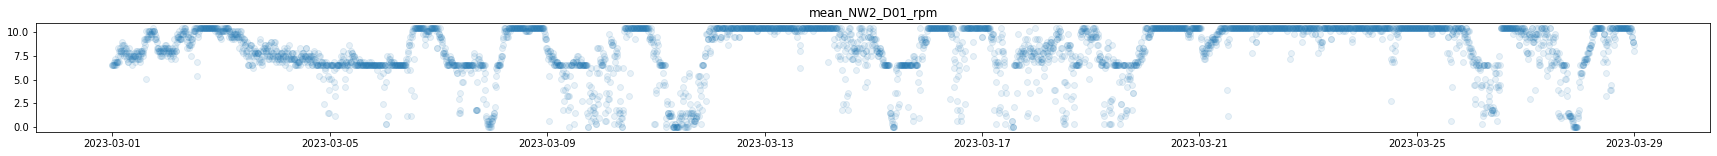

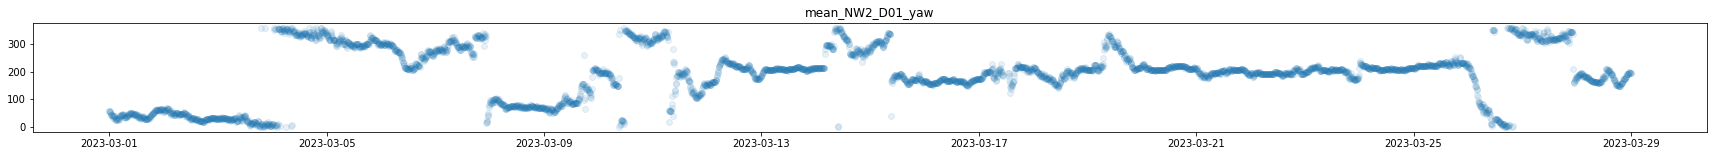

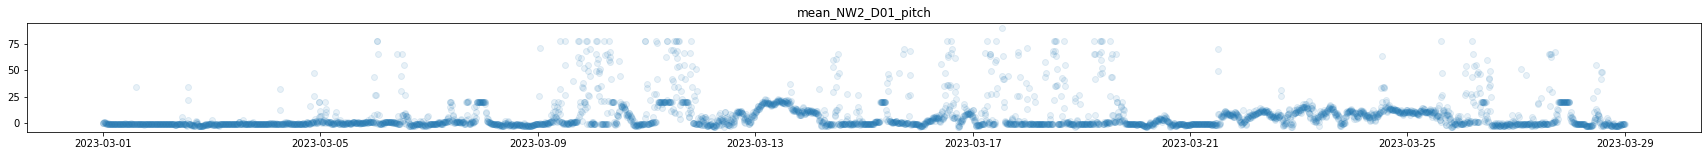

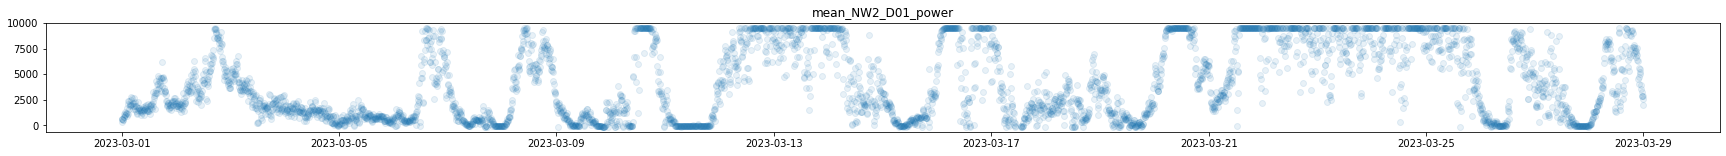

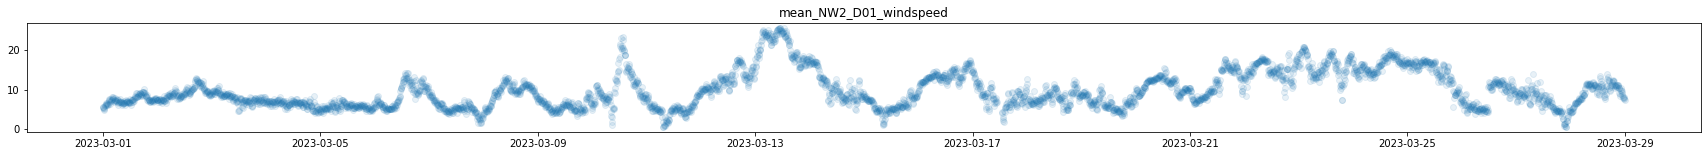

In [186]:
scatter_data = inputs.loc[stop_training:stop_training+datetime.timedelta(days=28)]
for i in range(len(scatter_data.columns)-1):
    plt.figure(figsize=(30,2))
    plt.scatter(scatter_data.index, scatter_data.iloc[:, i], alpha = 0.1)
    plt.title(str(scatter_data.columns[i]))
    plt.show()

In [182]:
inputs.loc[stop_training:stop_training+datetime.timedelta(days=28)]

,mvbc_WandelaarBuoy_Wave_height,mvbc_WandelaarBuoy_Sea_water_temperature,mvbc_WandelaarMeasuringpile_Tide_TAW,mvbc_WandelaarMeasuringpile_Air_pressure,mvbc_WandelaarMeasuringpile_Air_temperature,mean_NW2_D01_rpm,mean_NW2_D01_yaw,mean_NW2_D01_pitch,mean_NW2_D01_power,mean_NW2_D01_windspeed,mean_NW2_D01_winddirection
2023-03-01 00:00:00+00:00,72.000000,6.600000,117.000000,1029.900000,4.800000,6.565,57.743,0.224,663.936,5.648,55.925
2023-03-01 00:00:00+00:00,72.000000,6.600000,117.000000,1029.900000,4.800000,6.565,57.743,0.224,663.936,5.648,55.925
2023-03-01 00:10:00+00:00,71.666667,6.600000,114.000000,1029.866667,4.800000,6.565,57.436,0.056,643.456,5.453,57.548
2023-03-01 00:20:00+00:00,71.333333,6.600000,111.000000,1029.833333,4.800000,6.565,55.281,0.951,338.048,4.855,51.701
2023-03-01 00:30:00+00:00,71.000000,6.600000,108.000000,1029.800000,4.800000,6.565,54.330,0.671,523.968,5.180,55.421
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28 23:20:00+00:00,60.000000,8.433333,79.333333,1013.600000,8.000000,8.952,198.269,-1.063,2859.328,7.945,196.870
2023-03-28 23:30:00+00:00,58.000000,8.400000,78.000000,1013.500000,8.000000,8.952,195.276,-1.063,2870.848,8.016,195.527
2023-03-28 23:40:00+00:00,56.666667,8.400000,80.333333,1013.433333,7.966667,8.952,194.632,-1.063,2916.992,7.703,196.395
2023-03-28 23:50:00+00:00,55.333333,8.400000,82.666667,1013.366667,7.933333,8.654,194.632,-1.063,2619.776,7.902,194.241


In [151]:
p_val_mode

{}

In [149]:
p_val_mode

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D


In [123]:
testing_data.index[-1]

Timestamp('2023-05-04 00:00:00+0000', tz='UTC')

In [114]:
test_end

'SS1'

In [113]:
p_val_mode

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D


In [106]:
test_end

Timestamp('2023-03-01 23:50:00+0000', tz='UTC')

In [108]:
pd.DataFrame(p_vals, index=[test_end])

,no_scour,0.05D,0.1D,0.2D,0.3D,0.4D
2023-03-01 23:50:00+00:00,0.331662,0.003655,1.836540e-16,4.532211e-27,8.193553e-48,2.642764e-67


In [96]:
scouring_scenarios.copy()

['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']

In [58]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
scour_test = \
            testing_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode]['0.05D']/100 \
                *testing_data[mode]
            )
for mode in modes:
    print('no scour: ', mannwhitneyu(training_data[mode].dropna(), scour_test.dropna(), alternative='two-sided'))
    for scouring_scenario in scouring_scenarios:
        scour_population = \
            training_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *training_data[mode]
            )
        print(mode, scouring_scenario)
        print(mode, scouring_scenario, mannwhitneyu(scour_population.dropna(), scour_test.dropna(), alternative='two-sided'))


no scour:  MannwhitneyuResult(statistic=1154781.0, pvalue=0.32412821796617675)
SS1 0.05D
SS1 0.05D MannwhitneyuResult(statistic=1048777.5, pvalue=0.3316621087910807)
SS1 0.1D
SS1 0.1D MannwhitneyuResult(statistic=747429.0, pvalue=6.420967996544555e-11)
SS1 0.2D
SS1 0.2D MannwhitneyuResult(statistic=597001.0, pvalue=1.272796624930999e-20)
SS1 0.3D
SS1 0.3D MannwhitneyuResult(statistic=367589.0, pvalue=8.440809882634575e-42)
SS1 0.4D
SS1 0.4D MannwhitneyuResult(statistic=191319.0, pvalue=2.4712744303688214e-63)


In [59]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
scour_test = \
            testing_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode]['0.1D']/100 \
                *testing_data[mode]
            )
for mode in modes:
    print('no scour: ', mannwhitneyu(training_data[mode].dropna(), scour_test.dropna(), alternative='two-sided'))
    for scouring_scenario in scouring_scenarios:
        scour_population = \
            training_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *training_data[mode]
            )
        print(mode, scouring_scenario)
        print(mode, scouring_scenario, mannwhitneyu(scour_population.dropna(), scour_test.dropna(), alternative='two-sided'))


no scour:  MannwhitneyuResult(statistic=1453226.0, pvalue=8.290388191334566e-11)
SS1 0.05D
SS1 0.05D MannwhitneyuResult(statistic=1356793.0, pvalue=2.4158690186672647e-06)
SS1 0.1D
SS1 0.1D MannwhitneyuResult(statistic=1048777.5, pvalue=0.3316621087910807)
SS1 0.2D
SS1 0.2D MannwhitneyuResult(statistic=874169.0, pvalue=2.740736281662732e-05)
SS1 0.3D
SS1 0.3D MannwhitneyuResult(statistic=571587.0, pvalue=1.3775835519712026e-22)
SS1 0.4D
SS1 0.4D MannwhitneyuResult(statistic=307941.0, pvalue=1.419606813703375e-48)


In [69]:
# Change the amount of days in the testing data
stop_training = datetime.datetime(2023, 3, 1, tzinfo=utc)

training_data = normalized.loc[normalized.index < stop_training]
testing_data = normalized.loc[training_data.index[-1]:training_data.index[-1]+datetime.timedelta(days=2)]

In [70]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
for mode in modes:
    print('no scour: ', mannwhitneyu(training_data[mode].dropna(), testing_data[mode].dropna(), alternative='two-sided'))
    for scouring_scenario in scouring_scenarios:
        scour_population = \
            training_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *training_data[mode]
            )
        print(mode, scouring_scenario, mannwhitneyu(scour_population.dropna(), testing_data[mode].dropna(), alternative='two-sided'))

no scour:  MannwhitneyuResult(statistic=2228842.5, pvalue=0.7343615280004456)
SS1 0.05D MannwhitneyuResult(statistic=2030664.0, pvalue=0.025331224002672872)
SS1 0.1D MannwhitneyuResult(statistic=1468336.0, pvalue=1.3651124055241953e-21)
SS1 0.2D MannwhitneyuResult(statistic=1186996.0, pvalue=8.63827318772513e-40)
SS1 0.3D MannwhitneyuResult(statistic=745089.0, pvalue=4.904118149660728e-80)
SS1 0.4D MannwhitneyuResult(statistic=387025.0, pvalue=4.0300485364591836e-123)


In [71]:
modes = ['SS1']
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
scour_test = \
            testing_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode]['0.1D']/100 \
                *testing_data[mode]
            )
for mode in modes:
    print('no scour: ', mannwhitneyu(training_data[mode].dropna(), scour_test.dropna(), alternative='two-sided'))
    for scouring_scenario in scouring_scenarios:
        scour_population = \
            training_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *training_data[mode]
            )
        print(mode, scouring_scenario, mannwhitneyu(scour_population.dropna(), scour_test.dropna(), alternative='two-sided'))

no scour:  MannwhitneyuResult(statistic=2977048.0, pvalue=8.010447173917201e-24)
SS1 0.05D MannwhitneyuResult(statistic=2799454.0, pvalue=8.808870090609126e-15)
SS1 0.1D MannwhitneyuResult(statistic=2228842.5, pvalue=0.7343615280004456)
SS1 0.2D MannwhitneyuResult(statistic=1897021.0, pvalue=7.090605279478302e-05)
SS1 0.3D MannwhitneyuResult(statistic=1298642.0, pvalue=7.049668684929237e-32)
SS1 0.4D MannwhitneyuResult(statistic=730259.0, pvalue=1.2369564046864025e-81)


In [23]:
from statsmodels.stats.power import Power
from statsmodels.stats.power import TTestIndPower,TTestPower
from matplotlib import pyplot as plt
import numpy as np
power = 0.99
significance = 0.01
operating_condition = 'parked' # 'rated' or 'parked'
scouring_scenarios = ['0.05D', '0.1D', '0.2D', '0.3D', '0.4D']
modes = ['SS1', 'SS2', 'FA1', 'FA2']

In [14]:
# No normalization
normal_population_data = tracked_frequencies
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  4440.008518359691 , in days:  30.83
0.1D  nr of samples:  285.07932908807265 , in days:  1.98
0.2D  nr of samples:  141.8542667602522 , in days:  0.99
0.3D  nr of samples:  58.06053551695049 , in days:  0.4
0.4D  nr of samples:  28.326328566490133 , in days:  0.2
SS2
0.05D  nr of samples:  798.4315833499217 , in days:  5.54
0.1D  nr of samples:  54.37422582537139 , in days:  0.38
0.2D  nr of samples:  28.183875333498964 , in days:  0.2
0.3D  nr of samples:  12.591908278620204 , in days:  0.09
0.4D  nr of samples:  7.070749092619846 , in days:  0.05
FA1
0.05D  nr of samples:  24337.881722683564 , in days:  169.01
0.1D  nr of samples:  1556.0665029626773 , in days:  10.81
0.2D  nr of samples:  770.6085352508562 , in days:  5.35
0.3D  nr of samples:  310.94273607305837 , in days:  2.16
0.4D  nr of samples:  147.6694833274242 , in days:  1.03
FA2
0.05D  nr of samples:  460.69643432393997 , in days:  3.2
0.1D  nr of samples:  32.33064262366473 , in days:  0.22
0.2

In [15]:
# With normalization
normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  2629.361778093529 , in days:  18.26
0.1D  nr of samples:  169.46328237759195 , in days:  1.18
0.2D  nr of samples:  84.67443283750369 , in days:  0.59
0.3D  nr of samples:  35.084028791525796 , in days:  0.24
0.4D  nr of samples:  17.51263255913455 , in days:  0.12
SS2
0.05D  nr of samples:  172.65874917584162 , in days:  1.2
0.1D  nr of samples:  13.102588406645799 , in days:  0.09
0.2D  nr of samples:  7.574631120070531 , in days:  0.05
0.3D  nr of samples:  4.357189002114248 , in days:  0.03
0.4D  nr of samples:  3.2088707532883998 , in days:  0.02
FA1
0.05D  nr of samples:  9179.01313331245 , in days:  63.74
0.1D  nr of samples:  587.8390072567304 , in days:  4.08
0.2D  nr of samples:  291.64013411432967 , in days:  2.03
0.3D  nr of samples:  118.30473271101552 , in days:  0.82
0.4D  nr of samples:  56.747317971553244 , in days:  0.39
FA2
0.05D  nr of samples:  128.48331556495287 , in days:  0.89
0.1D  nr of samples:  10.292341051382692 , in days:  0.07
0

In [26]:
# With normalization

normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))

SS1
0.05D  nr of samples:  1317.1715260156782 , in days:  9.15
0.1D  nr of samples:  87.2571125981997 , in days:  0.61
0.2D  nr of samples:  44.89595568204568 , in days:  0.31
0.3D  nr of samples:  20.17332970083981 , in days:  0.14
0.4D  nr of samples:  11.450986015222695 , in days:  0.08
SS2
0.05D  nr of samples:  88.85419095749168 , in days:  0.62
0.1D  nr of samples:  9.256800633014 , in days:  0.06
0.2D  nr of samples:  6.4403935871830615 , in days:  0.04
0.3D  nr of samples:  4.604390193838766 , in days:  0.03
0.4D  nr of samples:  3.788868536663863 , in days:  0.03
FA1
0.05D  nr of samples:  4591.995394645047 , in days:  31.89
0.1D  nr of samples:  296.4188179130947 , in days:  2.06
0.2D  nr of samples:  148.3304146399079 , in days:  1.03
0.3D  nr of samples:  61.6927148359784 , in days:  0.43
0.4D  nr of samples:  30.961139757025 , in days:  0.22
FA2
0.05D  nr of samples:  66.77817763554351 , in days:  0.46
0.1D  nr of samples:  7.843625866994616 , in days:  0.05
0.2D  nr of sa

In [ ]:
def mann_withney_u_power_analysis(normal_data, shifted_data, alpha, power):
    """
    Calculate the required sample size for a Mann-Whitney U test with given
    effect size, alpha, and power.
    """

In [16]:
from scipy.stats import mannwhitneyu, norm
import numpy as np

def MWUPower(noraml_data, shifted_data, alpha=0.05, power=0.8, alternative='two-sided'):
    """
    Calculate the required sample size for a Mann-Whitney U test with given
    effect size, alpha, and power.
    """
    # calculate the effect size
    delta = (np.median(noraml_data) - np.median(shifted_data))/ noraml_data.std()

    
    z_alpha = norm.ppf(1 - (alpha/2))
    u_alpha = mannwhitneyu(noraml_data, shifted_data, alternative='two-sided')[1]
    
    # calculate the power for the given sample size
    power_m = 1 - norm.cdf((z_alpha - np.sqrt(m) * delta - u_alpha) / np.sqrt(1 + m / n1 + m / n2))
    
    # increase sample size until desired power is reached
    while power_m < power:
        m += 1
        power_m = 1 - norm.cdf((z_alpha - np.sqrt(m) * delta - u_alpha) / np.sqrt(1 + m / n1 + m / n2))
    
    n1_star = round(m / (1 + (n2 / n1)))
    n2_star = round(m / (1 + (n1 / n2)))
    
    return n1_star, n2_star

In [18]:
# With normalization
normal_population_data = normalized
for mode in modes:
    print(mode)
    for scouring_scenario in scouring_scenarios:
        normal_population = normal_population_data[mode]
        scour_population = \
            normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )


        effect_size = (normal_population.mean() - scour_population.mean()) / (normal_population.std())
        power_analysis = TTestIndPower()
        number_samples = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=significance, nobs1=None, ratio=1.0, alternative='two-sided')
        print(scouring_scenario, ' nr of samples: ', number_samples, ', in days: ', np.round(number_samples/144, 2))
        print(len(normal_population), len(scour_population), MWUPower(len(normal_population), len(scour_population), effect_size, alpha=significance, power=power, alternative='two-sided'))

SS1
0.05D  nr of samples:  2629.361778093529 , in days:  18.26
17281 17281 (4320, 4320)
0.1D  nr of samples:  169.46328237759195 , in days:  1.18
17281 17281 (4320, 4320)
0.2D  nr of samples:  84.67443283750369 , in days:  0.59
17281 17281 (4320, 4320)
0.3D  nr of samples:  35.084028791525796 , in days:  0.24
17281 17281 (4320, 4320)
0.4D  nr of samples:  17.51263255913455 , in days:  0.12
17281 17281 (4320, 4320)
SS2
0.05D  nr of samples:  172.65874917584162 , in days:  1.2
17281 17281 (4320, 4320)
0.1D  nr of samples:  13.102588406645799 , in days:  0.09
17281 17281 (4320, 4320)
0.2D  nr of samples:  7.574631120070531 , in days:  0.05
17281 17281 (4320, 4320)
0.3D  nr of samples:  4.357189002114248 , in days:  0.03
17281 17281 (4320, 4320)
0.4D  nr of samples:  3.2088707532883998 , in days:  0.02
17281 17281 (4320, 4320)
FA1
0.05D  nr of samples:  9179.01313331245 , in days:  63.74
17281 17281 (4320, 4320)
0.1D  nr of samples:  587.8390072567304 , in days:  4.08
17281 17281 (4320, 43

C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:47: RuntimeWarning: overflow encountered in long_scalars
  var_mw = n1 * n2 * (n1 + n2 + 1) / 12
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:50: RuntimeWarning: invalid value encountered in sqrt
  lambda_mw = (U - mu_mw) / np.sqrt(var_mw)
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:53: RuntimeWarning: invalid value encountered in sqrt
  u_alpha = mu_mw + z_alpha * np.sqrt(var_mw) + z_beta * np.sqrt(var_mw / n2)
C:\Users\Max\AppData\Local\Temp\ipykernel_23448\2705538810.py:56: RuntimeWarning: invalid value encountered in sqrt
  power_m = 1 - norm.cdf((u_alpha - mu_mw - lambda_mw * np.sqrt(var_mw)) / np.sqrt(var_mw))


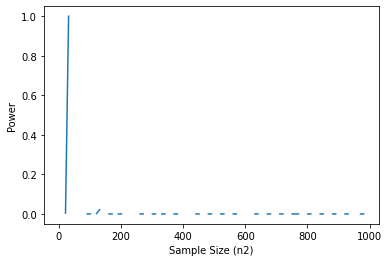

In [21]:
import numpy as np
from scipy.stats import mannwhitneyu

# Define effect size (mean difference between two groups)
delta = 0.5

# Set significance level and desired power
alpha = 0.05
power = 0.8

mode = 'SS1'
scouring_scenario = '0.05D'

normal_population_data = normalized
x1 = normal_population_data[mode]
x2 = normal_population_data[mode] \
            - (
                simulation_shifts[operating_condition+'_scour'][mode][scouring_scenario]/100 \
                *normal_population_data[mode]
            )
# Set sample size of the first dataset (x1)
n1 = len(x1)

# Set range of sample sizes for the second dataset (x2)
n2_range = np.arange(1, 1000, 10)

# effect_size
delta = (x1.mean() - x2.mean())/x1.std()

# Define function to calculate power for different sample sizes
def calculate_power(n1, n2, delta, alpha, power):
    # Generate two datasets with the given sample sizes and effect size
    x1 = np.random.normal(loc=0, scale=1, size=n1)
    x2 = np.random.normal(loc=delta, scale=1, size=n2)
    
    # Calculate the Mann-Whitney U test statistic and p-value
    U, p_value = mannwhitneyu(x1, x2, alternative='two-sided')
    
    # Calculate the critical value for rejecting the null hypothesis
    z_alpha = norm.ppf(1 - alpha/2)
    
    # Calculate the critical value for accepting the alternative hypothesis
    z_beta = norm.ppf(power)
    
    # Calculate the mean and standard deviation of the Mann-Whitney U distribution
    mu_mw = n1 * n2 / 2
    var_mw = n1 * n2 * (n1 + n2 + 1) / 12
    
    # Calculate the non-centrality parameter lambda
    lambda_mw = (U - mu_mw) / np.sqrt(var_mw)
    
    # Calculate the critical value for rejecting the null hypothesis based on the given power
    u_alpha = mu_mw + z_alpha * np.sqrt(var_mw) + z_beta * np.sqrt(var_mw / n2)
    
    # Calculate the power for the given sample sizes
    power_m = 1 - norm.cdf((u_alpha - mu_mw - lambda_mw * np.sqrt(var_mw)) / np.sqrt(var_mw))
    
    return power_m

# Calculate power for each sample size in n2_range
power_values = []
for n2 in n2_range:
    power_values.append(calculate_power(n1, n2, delta, alpha, power))

# Plot power as a function of sample size n2
import matplotlib.pyplot as plt

plt.plot(n2_range, power_values)
plt.xlabel('Sample Size (n2)')
plt.ylabel('Power')
plt.show()
